## City Life Case Study - Calculations (J. P. Gerber)
My overall approach was to run a Monte Carlo simulation.

In [73]:
import scipy.stats as s
import math as m
import pandas as pd
import numpy as np

def LogNormParam(x, y):
    ''' This function takes the 5th, 95th percentile values for a lognormal curve and returns
    the underlying normal sigma and mu'''
    #(calculate the parameters of normal curve by taking the log of the quantiles first)
    c_10 = m.log(x)
    c_90 = m.log(y)
    # Curve is symmetrical
    c_mean = (c_10 + c_90)/2
    # 5th/95th percentiles are at +- 1.645sd & symmetrical
    c_sd = (c_mean-c_10)/1.645
    return (c_mean, c_sd)

In [3]:
# 1. Let's specify all the two competing distributions
## CORPORATE FIRST ##
# Contacts = uniform from 15-25
c_contacts = [15,25]
c_contacts = s.uniform.rvs(loc=15, scale=10)
# Conversion rate = 25%
c_conversion = .25
# Donation amount = Lognormal from $50,000 to $1m (the tricky one)
c_don_mu, c_don_sigma = LogNormParam(50000,1000000)
c_donation = np.random.lognormal(c_don_mu, c_don_sigma)
# Life of grant is 100% funding from Poisson with lambda = 2
c_length = 2

## Red Jacket parameters
# Contacts = uniform from 200-500
r_contacts = [200,500]
#print(s.uniform.rvs(r_contacts[0], r_contacts[1] - r_contacts[0]))
# Conversion rate = 50%
r_conversion = .50
# Donation amount = Lognormal from $5,000 to $50,000
r_don_mu, r_don_sigma = LogNormParam(5000,50000)
r_donation = np.random.lognormal(r_don_mu, r_don_sigma)
# Life of donation is 100% then 50% then 10% in third year. This has an average longevity of
#1.6 years but we will model as a normal distribution with a 90% CI (as per specifications)
# with a lower limit of 1 year (because all donate in the first year)
#r_length = normalwith mean of 1.6 and SD of -1.645SD = 0.6
r_length_mu = 1.6
r_length_sd = .6/1.645

 

In [4]:
# 2. Basic formula for one development manager is
'''manager_return = contacts * conversion * donationamount * length'''

# 3. Monte Carlo of 10,000 samples for each of the two scenarios above

def CorporateMonteCarlo(min_contacts, max_contacts, conversion, donation_mu, donation_sigma, length, size=10000):
    '''This function takes parameters of distributions and returns Monte Carlo samples
    The conversion rate is fixed. Min_contacts is an integer of the minimum required 
    contacts, max_contacts should be an integer with the desired maximum, and donationamount 
    will be a list containing the mean and standard deviation of the normal distribution 
    underlying the lognormal distribution. Those can be calculated with the LogNormParam 
    function defined above. Length requires the lambda function constant.'''
    #3a Set up the matrix
    mc_samples = np.empty(size)
    length_samples = np.random.poisson(length, size)
    #3b/c Populate the Monte Carlo samples via a loop and work out the estimated return
    for i in range(size):
        contacts = s.uniform.rvs(min_contacts, max_contacts - min_contacts)
        donationamount = np.random.lognormal(donation_mu, donation_sigma)
        mc_samples[i] = contacts * conversion * donationamount * length_samples[i]
    
    return mc_samples    

def RedJacketMonteCarlo(min_contacts, max_contacts, conversion, donation_mu, donation_sigma, 
                        length_mu, length_sd, size=10000):
    '''This function takes parameters of distributions and returns Monte Carlo samples
    The conversion and length are fixed. Min_contacts is an integer of the minimum required 
    contacts, max_contacts should be an integer with the desired maximum, and donationamount 
    will be a list containing the mean and standard deviation of the normal distribution 
    underlying the lognormal distribution. Those can be calculated with the LogNormParam 
    function defined above. Length requires the lambda function constant.'''
    #3a Set up the matrix
    mc_samples = np.empty(size)
    #3b/c Populate the Monte Carlo samples via a loop and work out the estimated return
    for i in range(size):
        length = 1.6
        contacts = s.uniform.rvs(min_contacts, max_contacts - min_contacts)
        donationamount = np.random.lognormal(donation_mu, donation_sigma)
        length = np.random.normal(length_mu, length_sd)
        mc_samples[i] = contacts * conversion * donationamount * length    
    return mc_samples    

# Call this on both corporate and Red Jacket donors
c_mc = CorporateMonteCarlo(15, 25, c_conversion, c_don_mu, c_don_sigma, 5, size = 10000)
r_mc = RedJacketMonteCarlo(200, 500, r_conversion, r_don_mu, r_don_sigma, r_length_mu,
                           r_length_sd, size=10000)


Now we do some basic descriptive stats of our samples and a plot

In [71]:
# Define the mean and 90% CI for both groups
c_mc_mean, c_mc_lowerCI, c_mc_upperCI = np.mean(c_mc), np.percentile(c_mc,5), np.percentile(c_mc,95)

print('The mean for Corporate managers is $' + '{:,.0f}'.format(c_mc_mean) + 
      ' while the 90% confidence interval is from $' + '{:,.0f}'.format(c_mc_lowerCI) + ' to $' +
      '{:,.0f}'.format(c_mc_upperCI))

r_mc_mean, r_mc_lowerCI, r_mc_upperCI = np.mean(r_mc), np.percentile(r_mc,5), np.percentile(r_mc,95)

print('The mean for Red Jacket managers is $' + '{:,.0f}'.format(r_mc_mean) + 
      ' while the 90% confidence interval is from $' + '{:,.0f}'.format(r_mc_lowerCI) + ' to $' +
      '{:,.0f}'.format(r_mc_upperCI))

#3d Do a histogram of each (use code from Bayesian book as sample)

%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import seaborn as sns



The mean for Corporate managers is $8,380,253 while the 90% confidence interval is from $843,200 to $26,718,362
The mean for Red Jacket managers is $5,622,464 while the 90% confidence interval is from $1,102,194 to $15,223,260


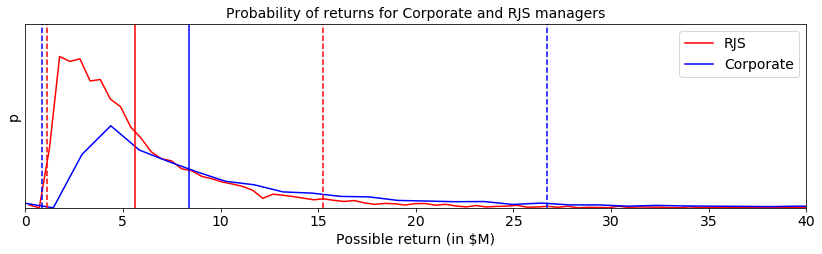

In [70]:
r_mc_low = r_mc/1000000
c_mc_low = c_mc/1000000
c_mc_mlo, c_mc_lowCIlo, c_mc_upCIlo = c_mc_mean/1000000, c_mc_lowerCI/1000000, c_mc_upperCI/1000000
r_mc_mlo, r_mc_lowCIlo, r_mc_upCIlo = r_mc_mean/1000000, r_mc_lowerCI/1000000, r_mc_upperCI/1000000

fig = plt.gcf()
fig.set_size_inches(14, 3.5)
plt.gcf().subplots_adjust(bottom=0.15)
_ = sns.kdeplot(r_mc_low, color='r', bw=.01, label = 'RJS')
_ = sns.kdeplot(c_mc_low, color='blue', bw=.01, label = 'Corporate')
_ = plt.axvline(c_mc_mlo, color='blue', linestyle='-')
_ = plt.axvline(r_mc_mlo, color='r', linestyle='-')
_ = plt.axvline(c_mc_lowCIlo, color='blue', linestyle='--')
_ = plt.axvline(r_mc_lowCIlo, color='r', linestyle='--')
_ = plt.axvline(c_mc_upCIlo, color='blue', linestyle='--')
_ = plt.axvline(r_mc_upCIlo, color='r', linestyle='--')
_ = plt.xlim([0,40])
_ = plt.ylim([0,.20])
_ = plt.title('Probability of returns for Corporate and RJS managers', fontsize=14)
_ = plt.legend(loc='upper right', fontsize=14)
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('Possible return (in $M)', fontsize=14)
_ = plt.ylabel('p', fontsize=14)
_ = plt.yticks([])
_ = plt.margins(1)
plt.savefig('SeabornFigs.png')
plt.show()
